In [1]:
import sys
sys.path.append('../src')
import torch
from semantic_bac_segment.models.pytorch_altmodel import UNET
from semantic_bac_segment.models.pytorch_attention import AttentionUNet

unet=UNET()
model_path='../data/models/state_weights/unet_model_expandedmask_7_best_model.pth'
#model_path='../data/models/state_weights/unet_model_expandedmask_attention_12_best_model.pth'
unet.from_pretrained(model_path)



UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, in

In [11]:
metadata[0]['model_params']['features']

[32, 64, 128]

In [13]:
metadata[0]['optimizer_params']['model_name']

'unet_model_expandedmask_17_-leakyrelu-32-128features'

In [57]:
from semantic_bac_segment.segmentator import Segmentator3

model_path='../data/models/state_weights/unet_model_expandedmask_17_-leakyrelu-4-128features-sigmoid-256patch_fine_tuned_best_model.pth'
bac_seg_monai=Segmentator3(model_path, UNET(features=[4, 8, 16, 32, 64, 128]), patch_size=256, overlap_ratio=0.10, half_precision=True)




(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x3116c31f0>)

<Figure size 1000x2000 with 0 Axes>

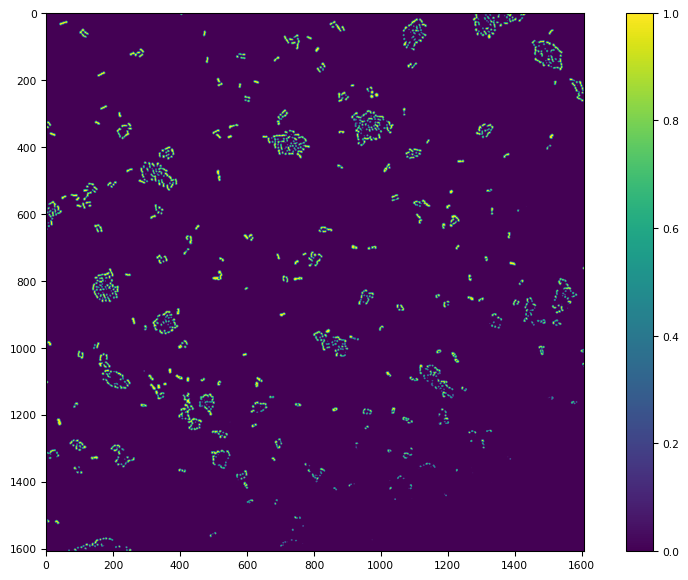

In [60]:
from semantic_bac_segment.utils import convert_image
import tifffile
import numpy as np


img=tifffile.imread('../data/source_norm/img_2.tiff')
predicted_imgs= bac_seg_monai.predict(img)
plt.figure(figsize=(10, 20))

#predicted_imgs=convert_image(predicted_imgs, np.uint8)
tifffile.imshow(predicted_imgs)

In [25]:

from semantic_bac_segment.utils import convert_image
import numpy as np
import os

input_folder='../data/source_norm/'
output_folder='../data/predictions_check'
list_images=os.listdir('../data/source_norm/')
for n, i in enumerate(list_images):
    print(f'image number {n + 1} of {len(list_images)}')
    image_path=os.path.join(input_folder, i)
    img=tifffile.imread(image_path)

    predicted_imgs= bac_seg_monai.predict(img)
    predicted_imgs=convert_image(predicted_imgs, np.uint8)

#    tifffile.imwrite(os.path.join(output_folder,i), predicted_imgs)


image number 1 of 31
image number 2 of 31
image number 3 of 31
image number 4 of 31
image number 5 of 31
image number 6 of 31
image number 7 of 31
image number 8 of 31
image number 9 of 31
image number 10 of 31
image number 11 of 31
image number 12 of 31
image number 13 of 31
image number 14 of 31
image number 15 of 31
image number 16 of 31
image number 17 of 31
image number 18 of 31
image number 19 of 31
image number 20 of 31
image number 21 of 31
image number 22 of 31
image number 23 of 31
image number 24 of 31
image number 25 of 31
image number 26 of 31
image number 27 of 31
image number 28 of 31
image number 29 of 31
image number 30 of 31
image number 31 of 31


In [41]:
import os
import json

dir_models='../data/models/state_weights/'

def list_files_with_pattern(directory, pattern):
    pth_files = []
    json_files = []

    for filename in os.listdir(directory):
        if pattern in filename:
            if filename.endswith('.pth'):
                pth_files.append(filename)
            elif filename.endswith('.json'):

                with open(os.path.join(directory, filename)) as f:
                    json_files.append(json.load(f))

    return pth_files, json_files

models, metadata= list_files_with_pattern(dir_models, '-4-128')

In [42]:
from semantic_bac_segment.loss_functions import DiceLoss
from semantic_bac_segment.utils import normalize_percentile, tensor_debbuger
from semantic_bac_segment.segmentator import Segmentator3

import time
# Image sources
input_folder='../data/source_norm/'
output_folder='../data/predictions_check'
list_images=os.listdir('../data/source_norm/')
mask_folder='../data/mask_cleaned_expanded/'
# Compare models
"""
model_list=['unet_model_test_2_best_model.pth',
            'unet_model_test_4_best_model.pth',
            'unet_model_expandedmask_16_weighted-leakyrelu_best_model.pth',
            'unet_model_expandedmask_15_weighteddice_best_model.pth',
            'unet_model_expandedmask_9_best_model.pth',
            'unet_model_expandedmask_8_best_model.pth',
            'unet_model_expandedmask_7_best_model.pth',
            'unet_model_expandedmask_12_attention_best_model.pth',
            'unet_model_expandedmask_13_best_model.pth',
            'unet_model_expandedmask_14_attention_best_model.pth'
            ]
dir_models='../data/models/state_weights/'
"""

#model_list=['unet_model_expandedmask_7_best_model.pth']
criterion=DiceLoss()

results=[]
for model_i, metadata_i in zip(models, metadata):
    features=metadata_i['model_params']['features']
    model_i=metadata_i['optimizer_params']['model_name']+'_best_model.pth'
    print(f'image number {model_i} of {len(models)}')
    model_i_path = os.path.join(dir_models, model_i)

    if 'attention' in model_i:

        bac_seg_monai=Segmentator3(model_i_path, AttentionUNet(), patch_size=128, overlap_ratio=0.10, half_precision=True)
    else:
        bac_seg_monai=Segmentator3(model_i_path, UNET(features=features), patch_size=256, overlap_ratio=0.10, half_precision=True)

    for n, i in enumerate(list_images):
        print(f'image number {n + 1} of {len(list_images)}')
        image_path=os.path.join(input_folder, i)
        mask_path=os.path.join(mask_folder, i)

        img=tifffile.imread(image_path)
        mask=tifffile.imread(mask_path)

        mask=normalize_percentile(mask)
        start_time = time.time()

        predicted_imgs= bac_seg_monai.predict(img)

        end_time = time.time()
        prediction_time = end_time - start_time
        loss=criterion(torch.from_numpy(mask), torch.from_numpy(predicted_imgs))
        loss_value=loss.item()
        print(loss_value)
        results.append({'Model': model_i, 'Image': i, 'Dice Loss': loss_value, 'Prediction Time': prediction_time})



image number unet_model_expandedmask_17_-leakyrelu-4-128features-sigmoid-256patch_best_model.pth of 1
image number 1 of 31
0.32233721017837524
image number 2 of 31
0.4741820693016052
image number 3 of 31
0.3166320323944092
image number 4 of 31
0.3818696141242981
image number 5 of 31
0.26608043909072876
image number 6 of 31
0.28777575492858887
image number 7 of 31
0.38226205110549927
image number 8 of 31
0.2566179037094116
image number 9 of 31
0.48719722032546997
image number 10 of 31
0.2643895149230957
image number 11 of 31
0.2614278793334961
image number 12 of 31
0.27424460649490356
image number 13 of 31
0.29690831899642944
image number 14 of 31
0.2821488380432129
image number 15 of 31
0.40217357873916626
image number 16 of 31
0.30506277084350586
image number 17 of 31
0.291637122631073
image number 18 of 31
0.3239879608154297
image number 19 of 31
0.4024909734725952
image number 20 of 31
0.3261268734931946
image number 21 of 31
0.4301491975784302
image number 22 of 31
0.37014299631118

In [8]:
import pandas as pd
df = pd.DataFrame(results)


In [15]:
df = combined_results

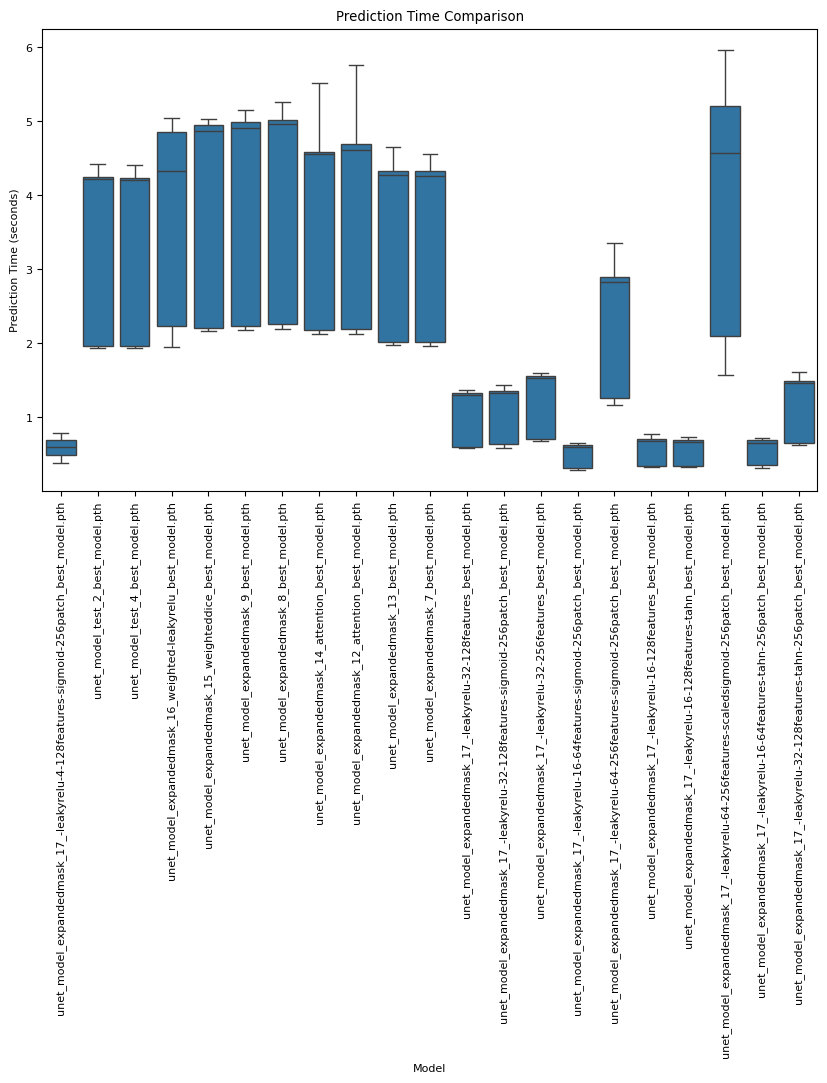

Model Summary:
                                                Model  Dice Loss  \
0   unet_model_expandedmask_12_attention_best_mode...   0.980247   
1           unet_model_expandedmask_13_best_model.pth   0.366155   
2   unet_model_expandedmask_14_attention_best_mode...   0.349129   
3   unet_model_expandedmask_15_weighteddice_best_m...   0.631687   
4   unet_model_expandedmask_16_weighted-leakyrelu_...   0.634664   
5   unet_model_expandedmask_17_-leakyrelu-16-128fe...   0.420337   
6   unet_model_expandedmask_17_-leakyrelu-16-128fe...   0.338816   
7   unet_model_expandedmask_17_-leakyrelu-16-64fea...   0.335506   
8   unet_model_expandedmask_17_-leakyrelu-16-64fea...   0.480930   
9   unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.424141   
10  unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.405662   
11  unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.378829   
12  unet_model_expandedmask_17_-leakyrelu-32-256fe...   0.350412   
13  unet_model_expandedmask_17_-l

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a boxplot of prediction times for each model using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Prediction Time', data=df)
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Time Comparison')
plt.show()

# Calculate average prediction time and accuracy for each model
model_summary = df.groupby('Model').agg({'Dice Loss': 'mean', 'Prediction Time': 'mean'}).reset_index()
print("Model Summary:")
print(model_summary)


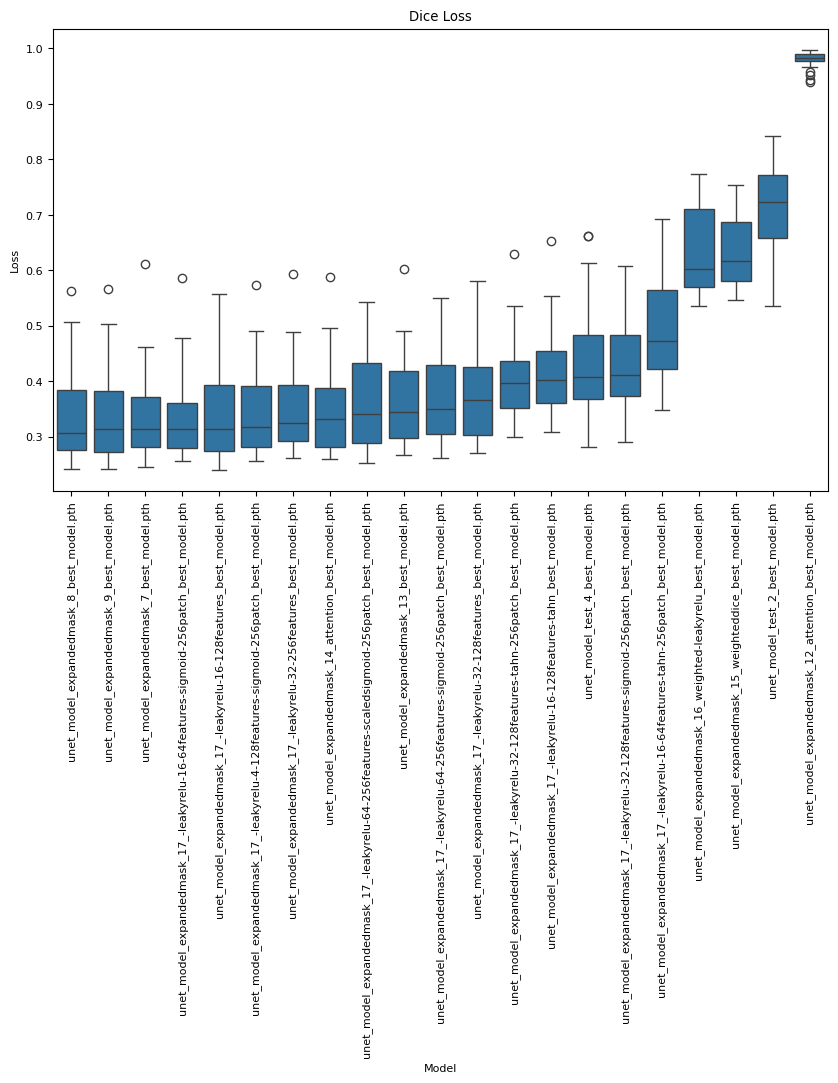

In [54]:
# Create a boxplot of prediction times for each model using Seaborn
# Group by model and calculate median
medians = df.groupby('Model')['Dice Loss'].median()

# Sort df by these median values
df['Median'] = df['Model'].map(medians)
sorted_df = df.sort_values('Median')

# Drop the temporary 'Median' column
sorted_df = sorted_df.drop(columns='Median')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice Loss', data=sorted_df)
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Loss')
plt.title('Dice Loss')
plt.show()



In [55]:
# Calculate mean and standard deviation for Dice Loss and Prediction Time
model_summary = df.groupby('Model').agg({'Dice Loss': ['mean', 'std'], 'Prediction Time': ['mean', 'std']}).reset_index()
model_summary.columns = ['Model', 'Dice Loss Mean', 'Dice Loss Std', 'Prediction Time Mean', 'Prediction Time Std']
model_summary['Dice Loss Std'] /= np.sqrt(31)
model_summary['Prediction Time Std'] /= np.sqrt(31)

# Create a new column 'Formatted Name' with line breaks
model_summary['Formatted Name'] = model_summary['Model'].str.replace('_', '\n')


/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_17415/2442840622.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.2, 1, 1])


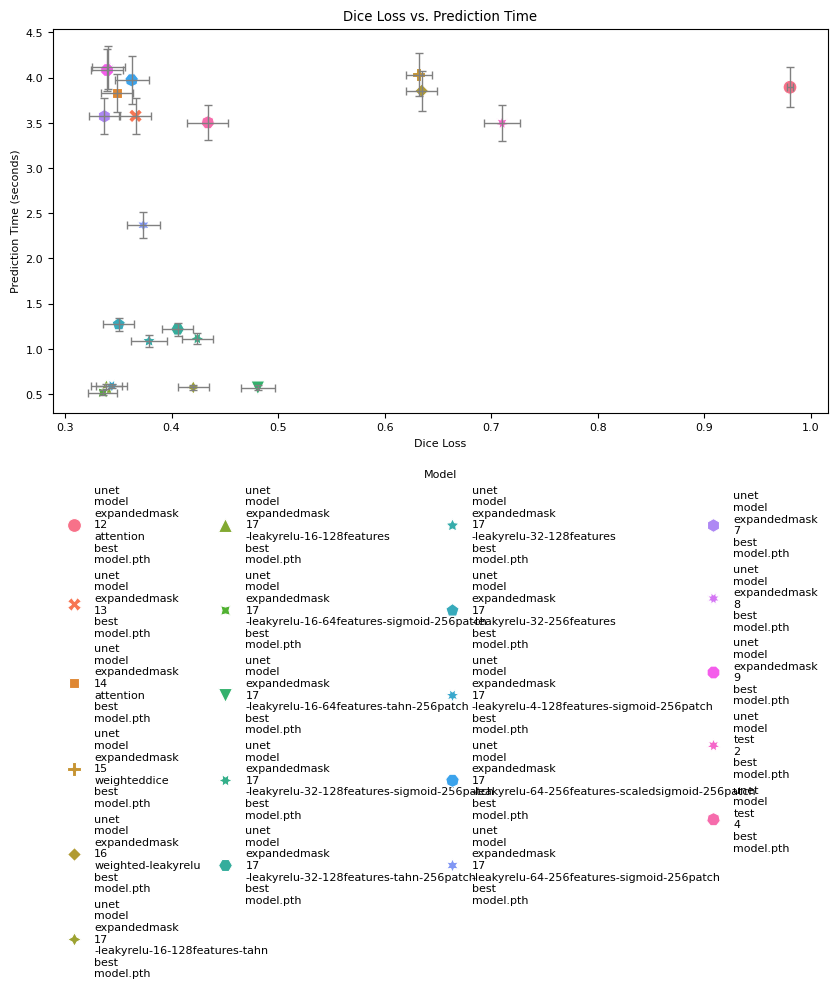

Model Summary:
                                                Model  Dice Loss Mean  \
0   unet_model_expandedmask_12_attention_best_mode...        0.980247   
1           unet_model_expandedmask_13_best_model.pth        0.366155   
2   unet_model_expandedmask_14_attention_best_mode...        0.349129   
3   unet_model_expandedmask_15_weighteddice_best_m...        0.631687   
4   unet_model_expandedmask_16_weighted-leakyrelu_...        0.634664   
5   unet_model_expandedmask_17_-leakyrelu-16-128fe...        0.420337   
6   unet_model_expandedmask_17_-leakyrelu-16-128fe...        0.338816   
7   unet_model_expandedmask_17_-leakyrelu-16-64fea...        0.335506   
8   unet_model_expandedmask_17_-leakyrelu-16-64fea...        0.480930   
9   unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.424141   
10  unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.405662   
11  unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.378829   
12  unet_model_expandedmask_17_-leak

In [56]:
# Create a scatter plot of Dice Loss vs. Prediction Time, colored by model, with error bars
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dice Loss Mean', y='Prediction Time Mean', data=model_summary, hue='Formatted Name', style='Formatted Name', s=100)
plt.errorbar(x=model_summary['Dice Loss Mean'], y=model_summary['Prediction Time Mean'],
             xerr=model_summary['Dice Loss Std'], yerr=model_summary['Prediction Time Std'],
             fmt='none', ecolor='gray', elinewidth=1, capsize=3)
plt.xlabel('Dice Loss')
plt.ylabel('Prediction Time (seconds)')
plt.title('Dice Loss vs. Prediction Time')

# Adjust legend settings
plt.legend(title='Model', bbox_to_anchor=(0, -1.5, 1, 0.2), loc='lower left', mode='expand', ncol=4, frameon=False)
plt.tight_layout(rect=[0, 0.2, 1, 1])
plt.subplots_adjust(bottom=0.4)
plt.show()

print("Model Summary:")
print(model_summary)

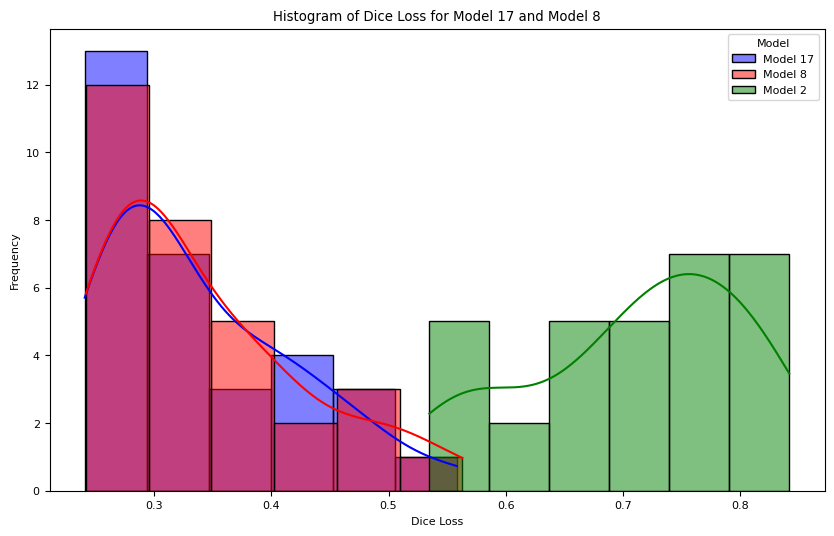

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the two models
df_filtered = df[df['Model'].isin(['unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth', 
                                   'unet_model_expandedmask_8_best_model.pth',
                                   'unet_model_test_2_best_model.pth'])]

# Create overlapping histograms
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth']['Dice Loss'], 
             color='blue', kde=True, alpha=0.5, label='Model 17')
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_expandedmask_8_best_model.pth']['Dice Loss'], 
             color='red', kde=True, alpha=0.5, label='Model 8')
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_test_2_best_model.pth']['Dice Loss'], 
             color='green', kde=True, alpha=0.5, label='Model 2')
plt.legend(title='Model')
plt.title('Histogram of Dice Loss for Model 17 and Model 8')
plt.xlabel('Dice Loss')
plt.ylabel('Frequency')
plt.show()

In [62]:
medians.sort_values()

Model
unet_model_expandedmask_8_best_model.pth                                                      0.306631
unet_model_expandedmask_9_best_model.pth                                                      0.313011
unet_model_expandedmask_7_best_model.pth                                                      0.313074
unet_model_expandedmask_17_-leakyrelu-16-64features-sigmoid-256patch_best_model.pth           0.313402
unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth                           0.314219
unet_model_expandedmask_17_-leakyrelu-4-128features-sigmoid-256patch_best_model.pth           0.316632
unet_model_expandedmask_17_-leakyrelu-32-256features_best_model.pth                           0.325075
unet_model_expandedmask_14_attention_best_model.pth                                           0.331201
unet_model_expandedmask_17_-leakyrelu-64-256features-scaledsigmoid-256patch_best_model.pth    0.341664
unet_model_expandedmask_13_best_model.pth                          